In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
    
aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
# import node
# import link
# #import quadraticassignmentcyt
from aequilibrae.paths.path_based import TrafficAssignmentCy

import utils

In [4]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")

In [13]:
%%time
scenario = "Anaheim" #"Berlin-Center" #
num_iters = 8
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 6 #
cvxopt.solvers.options['abstol'] =1e-11
cvxopt.solvers.options['reltol'] =1e-11
cvxopt.solvers.options['feastol'] =1e-11

print(f"{datetime.now()} - Running scenario {scenario}")

folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED  "berlin-center_net_clean_bpr_altered.tntp" #
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")


### Build data structures
bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes, ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)
print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")
bch.get_data_structure_with_by_directional_links()
### end build ds

### initialise Ass, add ds
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

    
### Ini solution, iter 0
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()
costs = [t_assignment.get_objective_function()]
gaps = [1] #initial gap, fix to arbitrary value or better compute it


### Iterations
od_path_times = {}
shortest_path_time = 0
opt_setup_time = 0
opt_solv_time = 0
update_time = 0
total_time = 0
for i in range(num_iters):
    print(f"  {datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        t1 = time.time()
        t_assignment.compute_shortest_paths(origin)
        t2 = time.time()
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        t3 = time.time()
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        t4 = time.time()
        t_assignment.update_path_flows(origin, solution)
        t5 = time.time()
        shortest_path_time += t2 - t1
        opt_setup_time += t3 - t2
        opt_solv_time += t4 - t3
        update_time += t5 - t4
        total_time += t5 - t1
        
    print(f"  {datetime.now()} - solved P(r) for all r and updated path flows")
    print(f"    runtime breakdown: dijkstra = {shortest_path_time:.2f}, opt setup = {opt_setup_time:.2f}, opt solver = {opt_solv_time:.2f}, update = {update_time:.2f}")
    print(f"                       dijkstra = {shortest_path_time/total_time:.0%}, opt setup = {opt_setup_time/total_time:.0%}, opt solver = {opt_solv_time/total_time:.0%}, update = {update_time/total_time:.0%}")
    

    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times,p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)
    print(f"  {datetime.now()} - computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")
print(f"{datetime.now()} - Done")

# Collect results
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_ = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-06 21:20:42.657305 - Running scenario Anaheim
2020-12-06 21:20:42.679987 - num nodes = 416, num links = 914
2020-12-06 21:20:43.984266 - performing initial solution
  2020-12-06 21:20:44.040171 - starting iteration 0
  2020-12-06 21:20:44.387782 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 0.02, opt setup = 0.07, opt solver = 0.24, update = 0.02
                       dijkstra = 5%, opt setup = 19%, opt solver = 69%, update = 6%
  2020-12-06 21:20:44.517316 - computed path times and flows, computed gap: 0.002751810602853011, computed objective: 1208761.5
  2020-12-06 21:20:44.517426 - starting iteration 1
  2020-12-06 21:20:44.931494 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 0.03, opt setup = 0.15, opt solver = 0.53, update = 0.04
                       dijkstra = 5%, opt setup = 19%, opt solver = 70%, update = 6%
  2020-12-06 21:20:44.944575 - computed path times and flows, computed gap: 0.0009102380030

In [14]:
%%time
bfw_res_ = utils.get_gradient_descent_solution(tntp_dir, scenario, link_file, block_centroids=False, rgap=5*1e-5)

CPU times: user 12.9 s, sys: 516 ms, total: 13.4 s
Wall time: 5.74 s


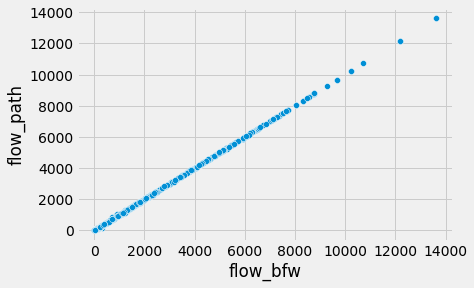

max diff in flow = 147.71699572357795
max rel diff in flow = 0.0


,link_id,a_node,b_node,ff_time,capacity,direction,flow_bfw,flow_path,abs_change,rel_change
704,704,354,355,1.0,5400,1,304.546982,156.829987,147.716996,0.485038
758,758,370,371,1.0,5400,1,925.147365,1048.339844,123.192479,0.133160
760,760,371,355,2.0,5400,1,713.051139,836.239624,123.188485,0.172762
756,756,370,354,2.0,5400,1,1121.615256,1022.432434,99.182822,0.088429
607,607,327,328,1.0,5400,1,870.071336,967.989258,97.917922,0.112540


In [15]:
d_ = bfw_res_.rename(columns={'time': 'ff_time'}).merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
#d_ = d_.drop(columns=['time_old', 'time_new'])
sns.scatterplot(data=d_, x='flow_bfw', y='flow_path');
plt.show();
d_['abs_change'] = np.abs(d_.flow_bfw - d_.flow_path)
d_['rel_change'] = d_['abs_change'] / d_['flow_bfw']
print(f"max diff in flow = {d_['abs_change'].max()}")
print(f"max rel diff in flow = {d_['rel_change'].min()}")
d_.sort_values(by=['abs_change'], ascending=False).head(5)

In [16]:
d_.sort_values(by=['abs_change'], ascending=False).head(20)

,link_id,a_node,b_node,ff_time,capacity,direction,flow_bfw,flow_path,abs_change,rel_change
704,704,354,355,1.000000,5400,1,304.546982,156.829987,147.716996,0.485038
758,758,370,371,1.000000,5400,1,925.147365,1048.339844,123.192479,0.133160
760,760,371,355,2.000000,5400,1,713.051139,836.239624,123.188485,0.172762
756,756,370,354,2.000000,5400,1,1121.615256,1022.432434,99.182822,0.088429
607,607,327,328,1.000000,5400,1,870.071336,967.989258,97.917922,0.112540
663,663,341,342,1.000000,5400,1,1231.149996,1136.061890,95.088106,0.077235
610,610,328,327,1.000000,5400,1,779.714005,702.345947,77.368058,0.099226
662,662,341,327,1.000000,5400,1,1508.940940,1578.589111,69.648171,0.046157
567,567,315,327,1.079924,5400,1,636.646585,695.150269,58.503684,0.091894
569,569,316,315,1.000000,5400,1,104.520137,161.350220,56.830083,0.543724
